<a href="https://colab.research.google.com/github/Rittaki/TDS_project/blob/main/tabular_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir dataset
! pip install --upgrade --force-reinstall --no-deps kaggle
!pip install tf-nightly-gpu==2.8.0.dev20211106

mkdir: cannot create directory ‘dataset’: File exists
  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
# data processing
import numpy as np
import pandas as pd

from math import sqrt

# Machine learning library
from sklearn.metrics import mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

%pip install mlxtend --upgrade
from mlxtend.evaluate import bias_variance_decomp

# data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


Reading the dataset from csv

In [ ]:
data_0 = pd.read_csv('Credit.csv', index_col='Unnamed: 0')
data_1 = pd.read_csv('house.csv', index_col='Id').replace(to_replace=np.nan, value=0)
cols = ["OverallQual","GrLivArea","GarageCars","GarageArea","TotalBsmtSF","FullBath","YearBuilt","YearRemodAdd",
         "LotFrontage","MSSubClass", "SalePrice"]
data_1 = data_1[cols]
data_2 = pd.read_csv('winequality-red.csv').replace(to_replace=np.nan, value=0)
data_3 = pd.read_csv('bodyfat.csv')
data = data_0
variance = []
bias = []
mse = []
rmse = []

Label Encoder for replacing the categorical value with a numeric value between 0 and the number of classes minus 1

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

columnsToEncode = list(data.select_dtypes(include=['category','object']))
for feature in columnsToEncode:
    try:
        data[feature] = le.fit_transform(data[feature])
    except:
        print('Error encoding ' + feature)

Split the data to train and validation set (80/20)

In [ ]:
from sklearn.model_selection import train_test_split

# print(data.isna().sum())
train, valid = train_test_split(data, test_size=0.2)
# train["LotFrontage"] = train["LotFrontage"].fillna(train["LotFrontage"].mean())
# valid["LotFrontage"] = valid["LotFrontage"].fillna(train["LotFrontage"].mean())
# separate X from y
size = len(train.columns)
x_train = train.iloc[: , :-1]
x_valid = valid.iloc[: , :-1]

y_train = train.iloc[: , -1:]
y_valid = valid.iloc[: , -1:]

Bias is:  309001.18422644504
Variance is:  2514.6168210050005
Mean:  548.892
Error rate:  220.29279897445582


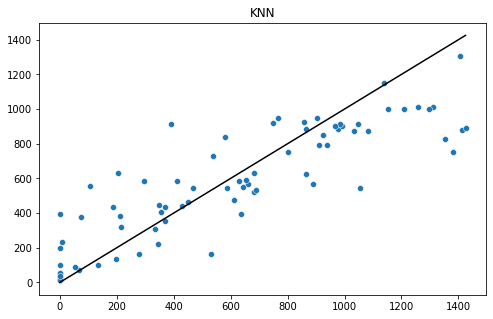

In [ ]:
# ------------------
# KNN PART (Regressor)
# ------------------

model_a = KNeighborsRegressor(n_neighbors=25)
m, b, v = bias_variance_decomp(model_a, x_train.values, y_train.values.flatten(),
                               x_valid.values, y_valid.values, loss='mse',
                               num_rounds=200, random_seed=123)

bias = np.append(bias, b)
variance = np.append(variance,v)
mse = np.append(mse,m)

print("Bias is: ", b/(len(y_valid)))
print("Variance is: ", v)

model_a.fit(x_train, y_train)
predicts = model_a.predict(x_valid)
print("Mean: ", predicts.mean())
error = sqrt(mean_squared_error(y_valid, predicts))
print("Error rate: ", error)
rmse = np.append(rmse,error)

#plt.scatter(x_valid.values.T, y_valid.values.reshape(80,1), color="black")
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(np.asarray(y_valid).reshape(-1), np.asarray(predicts).reshape(-1), ax=ax)
sns.lineplot(np.asarray(y_valid).reshape(-1),np.asarray(y_valid).reshape(-1),ax=ax,color='black')
ax.set_title("KNN")

plt.show()

Mean:  570.074875
Bias is:  360962.4616910187
Variance is:  3461.890786331281
Error rate:  89.47517393808184


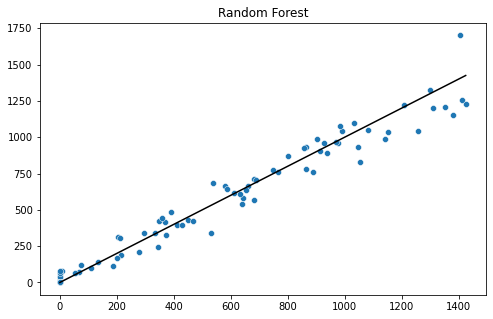

Variance Reduction: 37.67%
At the expense of introducing bias: 16.82%


In [ ]:
# ------------------
# RANDOM FOREST PART
# ------------------

model_b = RandomForestRegressor(n_estimators=100, random_state=10)

model_b.fit(x_train, y_train)

predicts = model_b.predict(x_valid)
print("Mean: ", predicts.mean())

m2, b2, v2 = bias_variance_decomp(model_b, x_train.values, y_train.values.flatten(), 
                                  x_valid.values, y_valid.values, loss='mse', 
                                  num_rounds=200, random_seed=123)

bias = np.append(bias, b2)
variance = np.append(variance,v2)
print("Bias is: ", b2/(len(y_valid)))
print("Variance is: ", v2)


error = sqrt(mean_squared_error(y_valid, predicts))
print("Error rate: ", error)
mse = np.append(mse,m2)
rmse = np.append(rmse,error)

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(np.asarray(y_valid).reshape(-1), predicts, ax=ax)
sns.lineplot(x = np.asarray(y_valid).reshape(-1), y = np.asarray(y_valid).reshape(-1), ax=ax,color='black')
ax.set_title("Random Forest")

plt.show()

print("Variance Reduction:", str(np.round((v2/v-1)*100,2))+ '%')
print("At the expense of introducing bias:", str(np.round((b2/b-1)*100, 2)) + '%')

Bias is:  370058.95505503163
Variance is:  368.9633932127587
Mean:  581.5729643686221
Error rate:  92.6194978598026


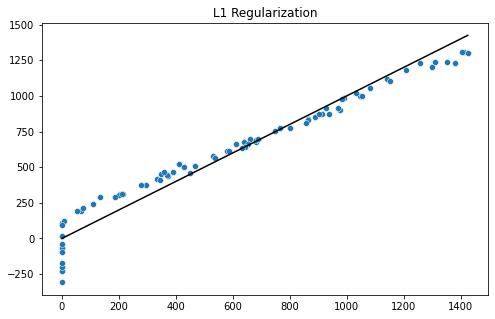

Variance Reduction: -85.33%
At the expense of introducing bias: 19.76%


In [ ]:
# -----------------
# L1 REGULARIZATION
# -----------------

model_e = linear_model.Lasso(alpha=0.01)
model_e.fit(x_train, y_train)
y_score = model_e.predict(x_valid)

m3, b3, v3 = bias_variance_decomp(model_e, x_train.values, y_train.values.flatten(), x_valid.values, y_valid.values, loss='mse', num_rounds=200, random_seed=123)
bias = np.append(bias, b3)
variance = np.append(variance,v3)
print("Bias is: ", b3/(len(y_valid)))
print("Variance is: ", v3)

print("Mean: ", y_score.mean())
error_lin = sqrt(mean_squared_error(y_valid, y_score))
print("Error rate: ", error_lin)
mse = np.append(mse,m3)
rmse = np.append(rmse,error_lin)

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(np.asarray(y_valid).reshape(-1), np.asarray(y_score).reshape(-1), ax=ax)
sns.lineplot(np.asarray(y_valid).reshape(-1), np.asarray(y_valid).reshape(-1), ax=ax,color='black')
ax.set_title("L1 Regularization")

plt.show()

print("Variance Reduction:", str(np.round((v3/v-1)*100,2))+ '%')
print("At the expense of introducing bias:", str(np.round((b3/b-1)*100, 2)) + '%')

Bias is:  368532.80271439935
Variance is:  368.098844355009
Mean:  581.7664642065165
Error rate:  93.653145034186


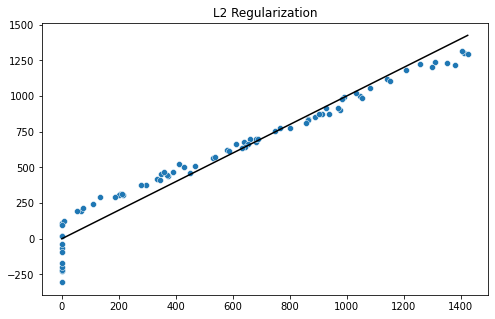

Variance Reduction: -85.36%
At the expense of introducing bias: 19.27%


In [ ]:
# -----------------
# L2 REGULARIZATION
# -----------------

model_c = Ridge()
model_c.fit(x_train, y_train)

# predict values of x_valid
y_score = model_c.predict(x_valid)
error_lin = sqrt(mean_squared_error(y_valid, y_score))

m4, b4, v4 = bias_variance_decomp(model_c, x_train.values, y_train.values.flatten(), x_valid.values, y_valid.values, loss='mse', num_rounds=200, random_seed=123)
bias = np.append(bias, b4)
variance = np.append(variance,v4)
print("Bias is: ", b4/(len(y_valid)))
print("Variance is: ", v4)

print("Mean: ", y_score.mean())
error_lin = sqrt(mean_squared_error(y_valid, y_score))
print("Error rate: ", error_lin)
rmse = np.append(rmse,error_lin)
mse = np.append(mse,m4)

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(np.asarray(y_valid).reshape(-1), np.asarray(y_score).reshape(-1), ax=ax)
sns.lineplot(np.asarray(y_valid).reshape(-1), np.asarray(y_valid).reshape(-1), ax=ax,color='black')
ax.set_title("L2 Regularization")

plt.show()

print("Variance Reduction:", str(np.round((v4/v-1)*100,2))+ '%')
print("At the expense of introducing bias:", str(np.round((b4/b-1)*100, 2)) + '%')

Bias is:  360852.3541599776
Variance is:  3395.0734815349374
Mean:  569.968375
Error rate:  86.8473017643611


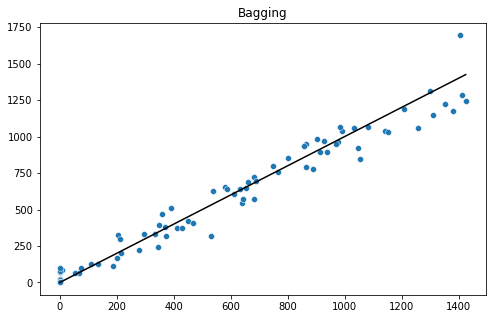

Variance Reduction: 35.01%
At the expense of introducing bias: 16.78%


In [ ]:
# ------------------------------------
# BAGGING (Bootstrap aggregating) PART
# ------------------------------------

regr = BaggingRegressor(base_estimator=None, n_estimators=100, random_state=1)
regr.fit(x_train, y_train)
y_score = regr.predict(x_valid)

m5, b5, v5 = bias_variance_decomp(regr, x_train.values, y_train.values.flatten(), 
                                  x_valid.values, y_valid.values, loss='mse', 
                                  num_rounds=200, random_seed=123)
bias = np.append(bias, b5)
variance = np.append(variance,v5)
print("Bias is: ", b5/(len(y_valid)))
print("Variance is: ", v5)

print("Mean: ", y_score.mean())
error_lin = sqrt(mean_squared_error(y_valid, y_score))
print("Error rate: ", error_lin)
rmse = np.append(rmse,error_lin)
mse = np.append(mse,m5)

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(np.asarray(y_valid).reshape(-1), np.asarray(y_score).reshape(-1), ax=ax)
sns.lineplot(np.asarray(y_valid).reshape(-1), np.asarray(y_valid).reshape(-1), ax=ax,color='black')
ax.set_title("Bagging")

plt.show()

print("Variance Reduction:", str(np.round((v5/v-1)*100,2))+ '%')
print("At the expense of introducing bias:", str(np.round((b5/b-1)*100, 2)) + '%')

In [ ]:
# ---------------------
# CROSS VALIDATION PART
# ---------------------

feat_num = len(x_train.columns)
# Create a cross-validation scheme
cv = KFold(n_splits=5, random_state=10, shuffle=True)

# Specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, feat_num + 1))}]

# Perform grid search
# 1. specify model

lin_mod = LinearRegression()
lin_mod.fit(x_train, y_train)
rfe = RFE(lin_mod) 

# 2. call GridSearchCV()
model_cv = GridSearchCV(estimator=rfe, param_grid=hyper_params, scoring='r2',
                        cv=cv, verbose=1, return_train_score=True)      
# fit the model
model_cv.fit(x_train, y_train)

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
result = model_cv.fit(x_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score: 0.94942136770197
Best Hyperparameters: {'n_features_to_select': 10}


So our Cross-Validation model will have 10 features (the number that we got for current run)

Bias is:  370093.3954991131
Variance is:  371.1520692970416
Mean:  581.5839165932917
Error rate:  92.61704859599224


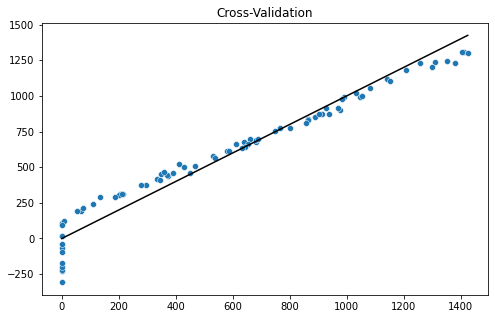

Variance Reduction: -85.24%
At the expense of introducing bias: 19.77%


In [ ]:
# final model
n_features_optimal = 10
lin_mod = LinearRegression()
lin_mod.fit(x_train, y_train)

rfe = RFE(lin_mod, n_features_to_select=n_features_optimal)           
rfe = rfe.fit(x_train, y_train)

# predict values of x_valid
y_score = rfe.predict(x_valid)
error_lin = sqrt(mean_squared_error(y_valid, y_score))

m6, b6, v6 = bias_variance_decomp(rfe, x_train.values, y_train.values.flatten(), x_valid.values, y_valid.values, loss='mse', num_rounds=200, random_seed=123)
bias = np.append(bias, b6)
variance = np.append(variance,v6)
rmse = np.append(rmse,error_lin)
mse = np.append(mse,m6)
print("Bias is: ", b6/(len(y_valid)))
print("Variance is: ", v6)

print("Mean: ", y_score.mean())
error_lin = sqrt(mean_squared_error(y_valid, y_score))
print("Error rate: ", error_lin)

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(np.asarray(y_valid).reshape(-1), np.asarray(y_score).reshape(-1), ax=ax)
sns.lineplot(np.asarray(y_valid).reshape(-1), np.asarray(y_valid).reshape(-1), ax=ax,color='black')
ax.set_title("Cross-Validation")

plt.show()

print("Variance Reduction:", str(np.round((v6/v-1)*100,2))+ '%')
print("At the expense of introducing bias:", str(np.round((b6/b-1)*100, 2)) + '%')

In [ ]:
# -------------------------------------
# CROSS VALIDATION + RANDOM FOREST PART
# -------------------------------------

feat_num = len(x_train.columns)
# Create a cross-validation scheme
cv = KFold(n_splits=5, random_state=10, shuffle=True)

# Specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, feat_num + 1))}]

# Perform grid search
# 1. specify model
rfe = RFE(model_b) 

# 2. call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = cv, 
                        verbose = 1,
                        return_train_score=True)  
model_cv.fit(x_train, y_train)

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)

result = model_cv.fit(x_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score: 0.9499672253961082
Best Hyperparameters: {'n_features_to_select': 4}


So our Cross-Validation & Random Forest model will have 4 features (the number that we got for current run)

Mean:  573.66175
Error rate:  81.70568038698413
Bias is:  368609.68527221767
Variance is:  3084.82597686975


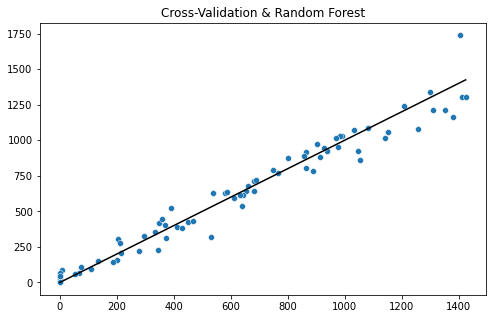

Variance Reduction: 22.68%
At the expense of introducing bias: 19.29%


In [ ]:
n_features_optimal = 4

rfe = RFE(model_b, n_features_to_select=n_features_optimal)            
rfe = rfe.fit(x_train, y_train)

# predict values of x_valid
y_score = rfe.predict(x_valid)

print("Mean: ", y_score.mean())
error_lin = sqrt(mean_squared_error(y_valid, y_score))
print("Error rate: ", error_lin)

m7, b7, v7 = bias_variance_decomp(rfe, x_train.values, y_train.values.flatten(), x_valid.values, y_valid.values, loss='mse', num_rounds=200, random_seed=123)
bias = np.append(bias, b7)
variance = np.append(variance,v7)
rmse = np.append(rmse,error_lin)
mse = np.append(mse,m7)
print("Bias is: ", b7/(len(y_valid)))
print("Variance is: ", v7)

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(np.asarray(y_valid).reshape(-1), np.asarray(y_score).reshape(-1), ax=ax)
sns.lineplot(np.asarray(y_valid).reshape(-1), np.asarray(y_valid).reshape(-1), ax=ax,color='black')
ax.set_title("Cross-Validation & Random Forest")

plt.show()

print("Variance Reduction:", str(np.round((v7/v-1)*100,2))+ '%')
print("At the expense of introducing bias:", str(np.round((b7/b-1)*100, 2)) + '%')

The A, B, C, D, E, F, G labels are state for Knn, Random Forest, Regularization 1, Regularization 2, Bagging, Cross-validation, Cross-validation + Random Forest

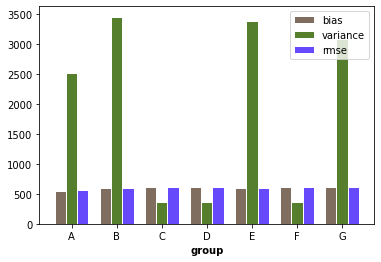

In [ ]:
bias1 = np.sqrt(bias/(len(y_valid)))

# Set position of bar on X axis
barWidth = 0.25

r1 = np.arange(len(bias))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bias1, color='#7f6d5f', width=barWidth, edgecolor='white', label='bias')
plt.bar(r2, variance, color='#557f2d', width=barWidth, edgecolor='white', label='variance')
plt.bar(r3, np.sqrt(mse), color='#6749fc', width=barWidth, edgecolor='white', label='rmse')

# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
labels = ['Knn','Random Forest','Regularizarion1','Regularizarion2','Bagging','Cross-validation','Cross-validation + Random Forest']
plt.xticks([r + barWidth for r in range(len(bias))], ['A', 'B', 'C', 'D', 'E','F','G'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

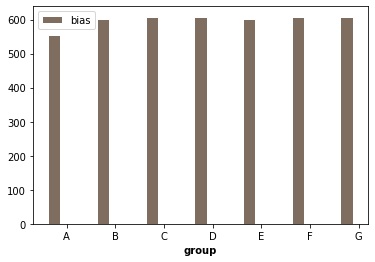

In [ ]:
barWidth = 0.25

r1 = np.arange(len(bias))

# Make the plot
plt.bar(r1, bias1, color='#7f6d5f', width=barWidth, edgecolor='white', label='bias')
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bias))], ['A', 'B', 'C', 'D', 'E','F','G'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

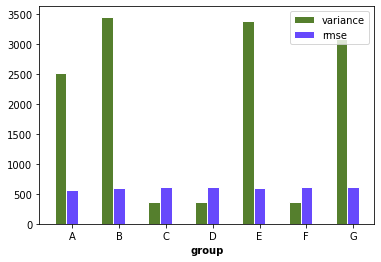

In [ ]:
barWidth = 0.25
 
# Make the plot
r2 = np.arange(len(variance))
r3 = [x + barWidth for x in r2]
plt.bar(r2, variance, color='#557f2d', width=barWidth, edgecolor='white', label='variance')
plt.bar(r3, np.sqrt(mse), color='#6749fc', width=barWidth, edgecolor='white', label='rmse')


# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(variance))], ['A', 'B', 'C', 'D', 'E','F','G'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

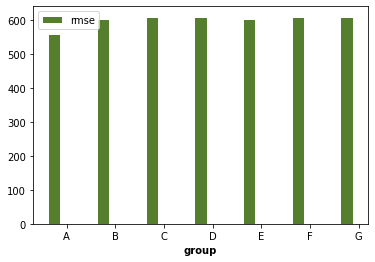

In [ ]:
barWidth = 0.25

# Make the plot
r2 = np.arange(len(variance))
plt.bar(r2, np.sqrt(mse), color='#557f2d', width=barWidth, edgecolor='white', label='rmse')

# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(variance))], ['A', 'B', 'C', 'D', 'E','F','G'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

After we sorted our results from the best to the worstest, this is the algorithm that we got that performs the best results:

In [ ]:
index = [0,1,2,3,4,5,6]

rmse,index = zip(*sorted(zip(rmse, index)))
min = index[0]


print("The best algorithm for this dataset is: ", end =" ")
print(labels[min])

The best algorithm for this dataset is:  Cross-validation + Random Forest
